 Text Classification with agreement-sentence-agreement-DFE

Import library

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#% matplotlib inline

In [8]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

Load data

In [9]:

df_train = pd.read_csv('agreement-sentence-agreement-DFE.csv', header=0, encoding = 'unicode_escape')


In [10]:
df_train.head()

,_unit_id,_unit_state,_trusted_judgments,_last_judgment_at,truth_response,truth_response:confidence,hypothesis,premise,truth_response_gold
0,679986253,finalized,5,2/22/15 0:32,yes,1.0000,Woman pushing a bicycle.,A woman in summer attire is walking with her b...,NaN
1,679986254,finalized,5,2/22/15 0:50,yes,1.0000,Woman pushing a bicycle.,"A girl in a white shirt, walking beside her bike.",NaN
2,679986255,finalized,5,2/22/15 1:47,yes,1.0000,Woman pushing a bicycle.,A woman walking a bike down a busy sidewalk.,NaN
3,679986256,finalized,5,2/22/15 1:13,no,0.6121,Woman pushing a bicycle.,A woman carrying her bike through a crowd.,NaN
4,679986257,finalized,5,2/22/15 0:46,yes,0.5831,A man sitting on an animal.,A boy rides a horse down a dusty country road.,NaN


Input: truth_response. Output: premise

In [11]:
from io import StringIO

col = ['truth_response', 'premise']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['premise'])]
df_train.columns = ['truth_response', 'premise']

df_train['category_id'] = df_train['truth_response'].factorize()[0]

category_id_df_train = df_train[['truth_response', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'truth_response']].values)

df_train.head()

,truth_response,premise,category_id
0,yes,A woman in summer attire is walking with her b...,0
1,yes,"A girl in a white shirt, walking beside her bike.",0
2,yes,A woman walking a bike down a busy sidewalk.,0
3,no,A woman carrying her bike through a crowd.,1
4,yes,A boy rides a horse down a dusty country road.,0


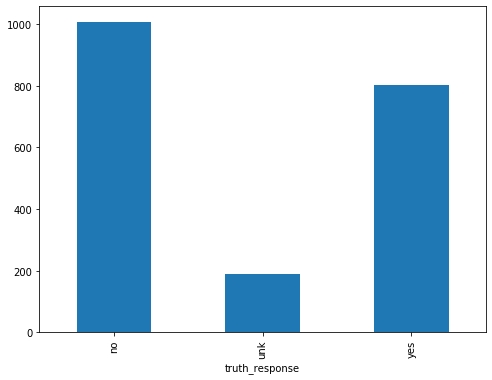

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,6))
df_train.groupby('truth_response').premise.count().plot.bar(ylim = 0)

plt.show()

In [13]:
df_train["category_id"].value_counts()

1    1008
0     803
2     189
Name: category_id, dtype: int64

Text Representation 

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df =5, ngram_range = (1, 3), strip_accents = 'unicode',
                            lowercase = True, stop_words = 'english', 
                             tokenizer = word_tokenize)


features = vectorizer.fit_transform(df_train.premise).toarray()

labels = df_train.category_id

features.shape


(2000, 835)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1,
                                                   random_state = 0)

                                               

Classification with Logistic Regression

In [24]:
lr = LogisticRegression(C = 10, class_weight = {0:0.07 , 1:1})
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight={0: 0.07, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
y_pred_train1 = lr.predict(X_train)

In [26]:
print(f1_score(y_train, y_pred_train1, pos_label = 'positive', average = 'micro'))

0.62


In [27]:
cm1 = confusion_matrix(y_train, y_pred_train1) 
cm1

array([[121, 559,  39],
       [  0, 903,   8],
       [  0,  78,  92]])

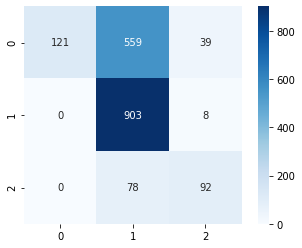

In [28]:
sns.heatmap(cm1, cmap="Blues", annot=True, square=True, fmt=".0f")

In [29]:
print(classification_report(y_train, y_pred_train1))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29       719
           1       0.59      0.99      0.74       911
           2       0.66      0.54      0.60       170

    accuracy                           0.62      1800
   macro avg       0.75      0.57      0.54      1800
weighted avg       0.76      0.62      0.54      1800



Classification with MultinomialNB

In [30]:
mnb = MultinomialNB(alpha = 0.1)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [31]:
y_pred_train2 = mnb.predict(X_train)

In [32]:
print(f1_score(y_train, y_pred_train2, pos_label = 'positive', average = 'micro'))

0.7127777777777777


In [33]:
cm2 = confusion_matrix(y_train, y_pred_train2) 
cm2

array([[480, 230,   9],
       [142, 756,  13],
       [ 41,  82,  47]])

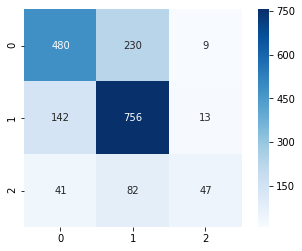

In [34]:
sns.heatmap(cm2, cmap="Blues", annot=True, square=True, fmt=".0f")

In [35]:
print(classification_report(y_train, y_pred_train2))

              precision    recall  f1-score   support

           0       0.72      0.67      0.69       719
           1       0.71      0.83      0.76       911
           2       0.68      0.28      0.39       170

    accuracy                           0.71      1800
   macro avg       0.70      0.59      0.62      1800
weighted avg       0.71      0.71      0.70      1800



Classification with Linear SVC

In [36]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C = 5, class_weight = {0 : 0.07, 1 : 1})
svc.fit(X_train, y_train)

LinearSVC(C=5, class_weight={0: 0.07, 1: 1}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [37]:
y_pred_train3 = svc.predict(X_train)

In [38]:
print(f1_score(y_train, y_pred_train3, pos_label = 'positive', average = 'micro'))

0.7616666666666667


In [39]:
cm3 = confusion_matrix(y_train, y_pred_train3) 
cm3

array([[343, 335,  41],
       [  4, 897,  10],
       [  0,  39, 131]])

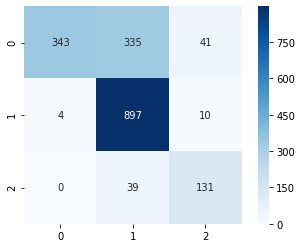

In [40]:
sns.heatmap(cm3, cmap="Blues", annot=True, square=True, fmt=".0f")

In [41]:
print(classification_report(y_train, y_pred_train3))

              precision    recall  f1-score   support

           0       0.99      0.48      0.64       719
           1       0.71      0.98      0.82       911
           2       0.72      0.77      0.74       170

    accuracy                           0.76      1800
   macro avg       0.80      0.74      0.74      1800
weighted avg       0.82      0.76      0.74      1800

